# Importation des librairies

In [73]:
# Suppression des avertissements liés à Scikit-learn
import warnings  # Masquer les avertissements (ex. : FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Librairies générales
import pandas as pd  # Librairie pour la manipulation de données
import numpy as np  # Librairie pour le calcul numérique
import sys  # Fonctions et variables liées à l'interpréteur Python
import copy  # Création de copies d'objets
from numpy import mean, std  # Fonctions de calcul de moyenne et d'écart type
import zipfile  # Traitement de fichiers zip
import os  # Manipulation de fichiers et chemins

# Librairie affichage
import matplotlib.pyplot as plt  # Outils de visualisation 2D
from matplotlib import pyplot  # Interface de la bibliothèque Matplotlib
import seaborn as sns  # Bibliothèque de visualisation de données basée sur Matplotlib

# Scikit-learn pour l'évaluation des modèles
from sklearn.metrics import confusion_matrix  # Matrice de confusion
from sklearn.model_selection import KFold  # Outils de validation croisée
from sklearn.metrics import accuracy_score  # Calcul de l'accuracy
from sklearn.model_selection import train_test_split  # Découpage train/test

# TensorFlow et Keras
import tensorflow as tf  # Librairie de deep learning
import keras  # API haut niveau pour construire et entraîner des modèles de deep learning
from keras import layers  # Modules de couches pour construire des modèles Keras
from keras import models  # Outils pour créer des modèles Keras
from keras import optimizers  # Outils d'optimisation
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Générateur d'images pour l'augmentation des données
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping  # Rappels pour le suivi et l'arrêt précoce
from keras.layers import Input, Dense, Dropout, Flatten, Lambda  # Types de couches Keras
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D  # Couches convolutionnelles et de pooling
from keras.preprocessing import image  # Outils de prétraitement d'images
from tensorflow.keras.models import Model, load_model  # Définition / chargement de modèles
from keras.datasets import fashion_mnist  # Jeu de données Fashion MNIST
from tensorflow.keras.utils import to_categorical  # Conversion en encodage one-hot
from tensorflow.keras.optimizers import SGD  # Optimiseur Stochastic Gradient Descent
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input  # Modèle ResNet50 pré-entraîné
from tensorflow.keras.preprocessing import image  # Prétraitement d'images pour les modèles Keras

# Extraction du dataset

In [60]:
import os
import zipfile
import requests

zip_file = "dataset.zip"
link = "https://www.lirmm.fr/~poncelet/Ressources/Data_sheep_cat_elephant_with_caption_600.zip"
dataset_name = "Data_sheep_cat_elephant_with_caption_600"

os.makedirs('./data/dataset/', exist_ok=True)

response = requests.get(link, stream=True)
if response.status_code == 200:
    with open(zip_file, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
else:
    raise Exception(f"Failed to download file. Status code: {response.status_code}")

with zipfile.ZipFile(zip_file, "r") as zip_ref:
    zip_ref.extractall("./data/dataset/" + dataset_name)

os.remove(zip_file)
print("Download and extraction complete!")

Download and extraction complete!


# Fonctions

## Chargement du dataset

In [ ]:
def load_dataset(data_dir, img_size=(224,224), batch_size=32, seed=42):

    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.3,
        subset="training",
        seed=seed,
        image_size=img_size,
        batch_size=batch_size,
        label_mode="categorical"
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.3,
        subset="validation",
        seed=seed,
        image_size=img_size,
        batch_size=batch_size,
        label_mode="categorical"
    )

    class_names = train_ds.class_names
    num_classes = len(class_names)

    # ResNet preprocessing
    train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
    val_ds   = val_ds.map(lambda x, y: (preprocess_input(x), y))

    train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
    val_ds   = val_ds.prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds, num_classes, class_names

## Visualisation de loss et d'accuracy

In [75]:
def plot_curves(histories):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    epochs = range(len(histories[0].history['loss']))
    
    train_loss = [history.history['loss'] for history in histories]
    val_loss = [history.history['val_loss'] for history in histories]
    train_acc = [history.history['accuracy'] for history in histories]
    val_acc = [history.history['val_accuracy'] for history in histories]

    mean_loss = np.mean(train_loss, axis=0)
    std_loss = np.std(train_loss, axis=0)
    mean_val_loss = np.mean(val_loss, axis=0)
    std_val_loss = np.std(val_loss, axis=0)
    mean_acc = np.mean(train_acc, axis=0)
    std_acc = np.std(train_acc, axis=0)
    mean_val_acc = np.mean(val_acc, axis=0)
    std_val_acc = np.std(val_acc, axis=0)

    train_color = '#2ca02c'
    val_color = '#9467bd'

    ax1.plot(epochs, mean_loss, color=train_color, label='Train')
    ax1.fill_between(epochs, mean_loss - std_loss, mean_loss + std_loss, color=train_color, alpha=0.2)
    ax1.plot(epochs, mean_val_loss, color=val_color, label='Validation')
    ax1.fill_between(epochs, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, color=val_color, alpha=0.2)
    ax2.plot(epochs, mean_acc, color=train_color, label='Train')
    ax2.fill_between(epochs, mean_acc - std_acc, mean_acc + std_acc, color=train_color, alpha=0.2)
    ax2.plot(epochs, mean_val_acc, color=val_color, label='Validation')
    ax2.fill_between(epochs, mean_val_acc - std_val_acc, mean_val_acc + std_val_acc, color=val_color, alpha=0.2)
    
    k = len(histories)

    ax1.set_title(f'Loss (k={k})')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax2.set_title(f'Accuracy (k={k})')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.show()

## Création du modèle

In [76]:
def create_model(input_shape, num_classes):

    base_model = ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape
    )

    base_model.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

## Evaluation du modèle

In [77]:
def train_model(model, train_ds, val_ds, epochs=5):

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs
    )

    return history

# Test

Found 1800 files belonging to 3 classes.
Using 1260 files for training.
Found 1800 files belonging to 3 classes.
Using 540 files for validation.
Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 678ms/step - accuracy: 0.8175 - loss: 0.4724 - val_accuracy: 0.9333 - val_loss: 0.2106
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 26s 650ms/step - accuracy: 0.9357 - loss: 0.1838 - val_accuracy: 0.9407 - val_loss: 0.1787
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 26s 648ms/step - accuracy: 0.9524 - loss: 0.1260 - val_accuracy: 0.9463 - val_loss: 0.1687
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 25s 624ms/step - accuracy: 0.9659 - loss: 0.1007 - val_accuracy: 0.9389 - val_loss: 0.1674
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 26s 657ms/step - accuracy: 0.9754 - loss: 0.0724 - val_accuracy: 0.9352 - val_loss: 0.1699


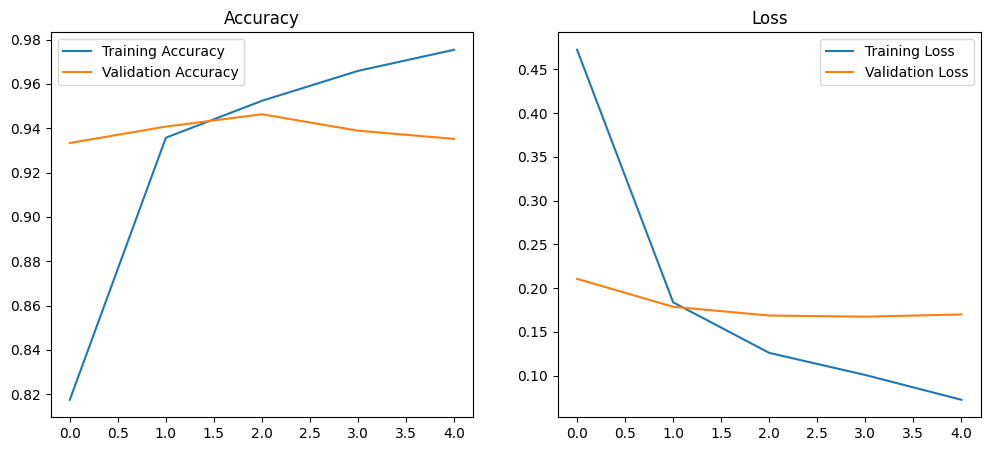

In [79]:
data_dir = "./data/dataset/Data_sheep_cat_elephant_with_caption_600/images"

train_ds, val_ds, num_classes, class_names = load_dataset(data_dir)

model = create_model(
    input_shape=(224,224,3),
    num_classes=num_classes
)

history = train_model(model, train_ds, val_ds, epochs=5)

def plot_history(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    # Loss
    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()

plot_history(history)

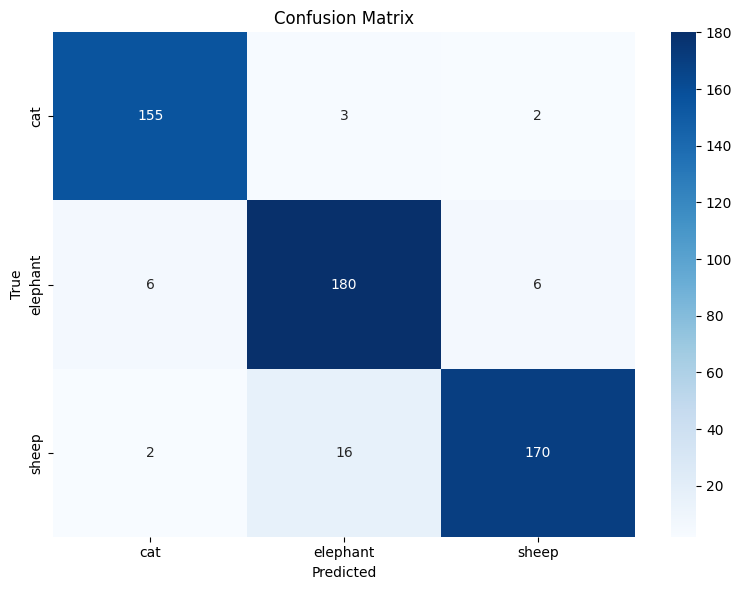

In [82]:
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)

    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

conf = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(conf,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()